In [1]:
pwd

'/Users/adriansoto/Library/CloudStorage/GoogleDrive-adrian.soto6@gmail.com/My Drive/Maestria/Academics/Term 3/Capstone /capstone_project/scripts'

In [2]:
import pandas as pd
import numpy as np

clients = pd.read_csv('../data/processed/clients.csv')
orders = pd.read_csv('../data/processed/orders.csv')
orders_raw = pd.read_csv('../data/processed/orders_raw.csv')

In [3]:
# Check balance: include both count and percentage columns
balance_counts = clients['class'].value_counts().rename_axis('class').reset_index(name='count')
balance_percent = clients['class'].value_counts(normalize=True).rename_axis('class').reset_index(name='percentage')
balance = pd.merge(balance_counts, balance_percent, on='class')
(balance)

,class,count,percentage
0,HighTicket_Efficient,19280,0.459595
1,LowTicket_Efficient,14993,0.357402
2,HighTicket_Inefficient,4137,0.098617
3,LowTicket_Inefficient,3540,0.084386


Our main objective is optimizing **HighTicket_Inefficient** (Q1) & **LowTicket_Inefficient** (Q3) 

<Axes: title={'center': 'Clients to Optimize by Class'}, xlabel='class'>

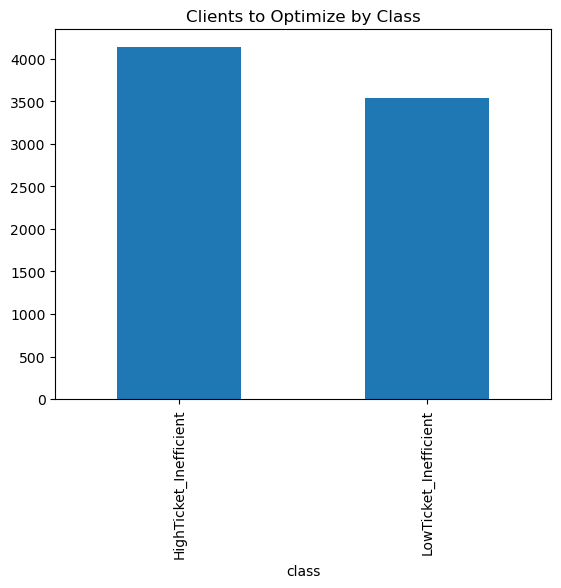

In [4]:
clients_to_optimize = clients[clients['class'].isin(['HighTicket_Inefficient', 'LowTicket_Inefficient'])]
clients_to_optimize['class'].value_counts()
# Our main objective is optimizing **HighTicket_Inefficient** (Q1) & **LowTicket_Inefficient** (Q3)
clients_to_optimize['class'].value_counts().plot(kind='bar', title='Clients to Optimize by Class')

In [5]:
clients_to_optimize.head()



,client_id,city,channel,promotor_id,frequency,efficiency,efficiency_scaled,total_orders,total_volume,total_income,...,median_promotor_calls,total_promotor_calls,class,zero_visit_flag,avg_orders_per_month,avg_visits_per_month,visit_order_gap,inefficiency_cost,profit_per_visit,opportunity_cost
2,100042162,Barcelona,HR,455263770,1.0,0.25,0.0125,14,1812.850,2243.30,...,0.0,0.0,HighTicket_Inefficient,False,1.166667,3.666667,2.500000,37.50,28.711364,71.778409
9,100179704,Barcelona,AR,9820087,1.0,0.50,0.0250,1,81.570,88.33,...,2.0,2.0,HighTicket_Inefficient,False,0.083333,0.166667,0.083333,1.25,24.165000,2.013750
15,100262932,Barcelona,HR,101664247,1.0,0.50,0.0250,16,940.354,2934.19,...,0.0,0.0,HighTicket_Inefficient,False,1.333333,2.000000,0.666667,10.00,95.591250,63.727500
18,100349828,Madrid,HR,268093511,1.0,0.25,0.0125,16,1115.169,4008.34,...,0.0,0.0,HighTicket_Inefficient,False,1.333333,3.666667,2.333333,35.00,65.644091,153.169545
19,100363218,Santander,AR,77675001,3.0,0.75,0.0375,33,2034.440,2115.68,...,0.0,0.0,LowTicket_Inefficient,False,2.750000,4.000000,1.250000,18.75,-4.048333,-5.060417


In [6]:
clients_to_optimize.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7677 entries, 2 to 41947
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   client_id               7677 non-null   int64  
 1   city                    7677 non-null   object 
 2   channel                 7677 non-null   object 
 3   promotor_id             7677 non-null   int64  
 4   frequency               7677 non-null   float64
 5   efficiency              7677 non-null   float64
 6   efficiency_scaled       7677 non-null   float64
 7   total_orders            7677 non-null   int64  
 8   total_volume            7677 non-null   float64
 9   total_income            7677 non-null   float64
 10  total_cost              7677 non-null   int64  
 11  total_profit            7677 non-null   float64
 12  median_ticket           7677 non-null   float64
 13  median_ticket_min       7677 non-null   float64
 14  median_ticket_max       7677 non-null   floa

<Figure size 1000x600 with 0 Axes>

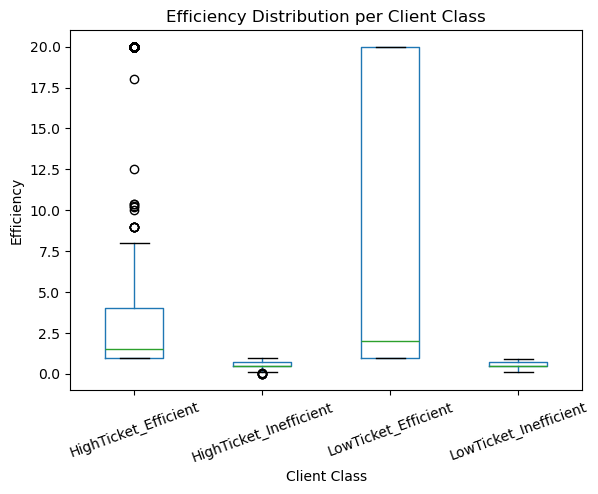

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
clients.boxplot(column='efficiency', by='class', grid=False)
plt.title('Efficiency Distribution per Client Class')
plt.suptitle('')
plt.xlabel('Client Class')
plt.ylabel('Efficiency')
plt.xticks(rotation=20)
plt.show()

<Figure size 1000x600 with 0 Axes>

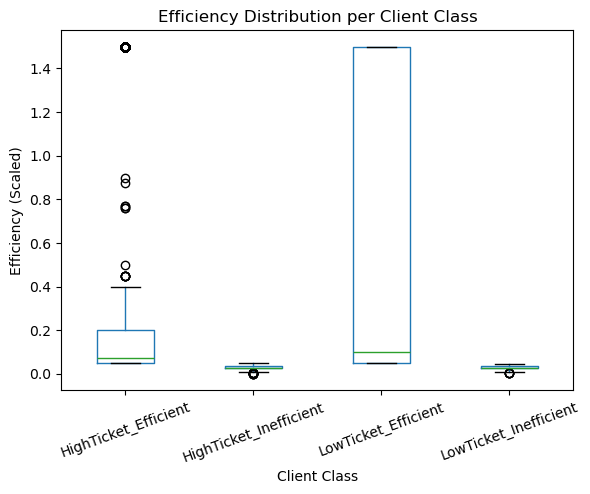

In [8]:

plt.figure(figsize=(10, 6))
clients.boxplot(column='efficiency_scaled', by='class', grid=False)
plt.title('Efficiency Distribution per Client Class')
plt.suptitle('')
plt.xlabel('Client Class')
plt.ylabel('Efficiency (Scaled)')
plt.xticks(rotation=20)
plt.show()

In [9]:
clients.groupby('class')['efficiency'].describe()

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
HighTicket_Efficient,19280.0,6.002680,7.902011,1.000,1.0,1.5,4.00,20.000000
HighTicket_Inefficient,4137.0,0.564889,0.171221,0.000,0.5,0.5,0.75,0.958333
LowTicket_Efficient,14993.0,8.058167,8.770722,1.000,1.0,2.0,20.00,20.000000
LowTicket_Inefficient,3540.0,0.546881,0.158122,0.125,0.5,0.5,0.75,0.937500


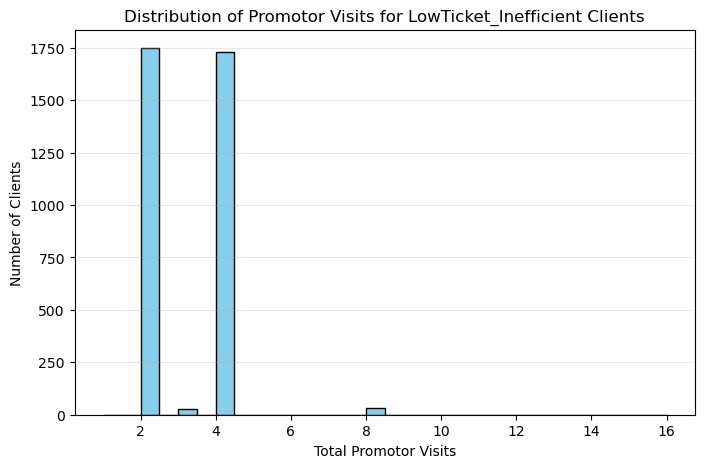

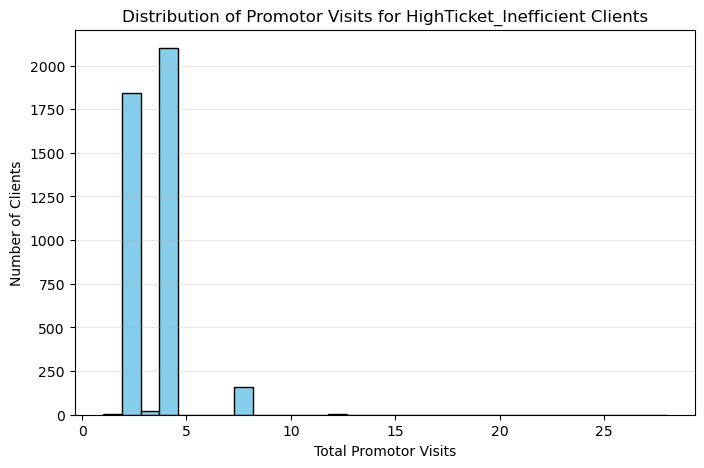

In [10]:
import matplotlib.pyplot as plt
# Review the Median promotor visits per each efficiency of clients to optimize 
# Filter for LowTicket_Inefficient clients
low_ticket_inefficient = clients_to_optimize[clients_to_optimize['class'] == 'LowTicket_Inefficient']

plt.figure(figsize=(8, 5))
plt.hist(low_ticket_inefficient['median_promotor_visits'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Promotor Visits for LowTicket_Inefficient Clients')
plt.xlabel('Total Promotor Visits')
plt.ylabel('Number of Clients')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Filter for HighTicket_Inneficient
high_ticket_inefficient = clients_to_optimize[clients_to_optimize['class'] == 'HighTicket_Inefficient']

plt.figure(figsize=(8, 5))
plt.hist(high_ticket_inefficient['median_promotor_visits'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Promotor Visits for HighTicket_Inefficient Clients')
plt.xlabel('Total Promotor Visits')
plt.ylabel('Number of Clients')
plt.grid(axis='y', alpha=0.3)
plt.show()

The objective is to increase efficiency, we having as a target to be as efficient as the efficient classes. 

-  **HighTicket_Inefficient  (Q1)** Target Efficiency = 6 
-  **LowTicket_Inefficient (Q3)** Target Efficiency = 8

In [11]:
clients_to_optimize.groupby('class')[['efficiency']].describe()

efficiency                                             \
                            count      mean       std    min  25%  50%   75%   
class                                                                          
HighTicket_Inefficient     4137.0  0.564889  0.171221  0.000  0.5  0.5  0.75   
LowTicket_Inefficient      3540.0  0.546881  0.158122  0.125  0.5  0.5  0.75   

                                  
                             max  
class                             
HighTicket_Inefficient  0.958333  
LowTicket_Inefficient   0.937500

In [12]:
clients_to_optimize.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7677 entries, 2 to 41947
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   client_id               7677 non-null   int64  
 1   city                    7677 non-null   object 
 2   channel                 7677 non-null   object 
 3   promotor_id             7677 non-null   int64  
 4   frequency               7677 non-null   float64
 5   efficiency              7677 non-null   float64
 6   efficiency_scaled       7677 non-null   float64
 7   total_orders            7677 non-null   int64  
 8   total_volume            7677 non-null   float64
 9   total_income            7677 non-null   float64
 10  total_cost              7677 non-null   int64  
 11  total_profit            7677 non-null   float64
 12  median_ticket           7677 non-null   float64
 13  median_ticket_min       7677 non-null   float64
 14  median_ticket_max       7677 non-null   floa

In [13]:
clients_to_optimize[['avg_visits_per_month']].describe()

,avg_visits_per_month
count,7677.000000
mean,1.969812
std,1.517430
min,0.083333
25%,0.666667
50%,1.666667
75%,3.333333
max,16.000000


In [14]:
# The objective is to increase efficiency, we having as a target to be as efficient as the efficient classes, which is one oder per visit. 
# -  **HighTicket_Inefficient  (Q1)** Target Efficiency = 1 
# -  **LowTicket_Inefficient (Q3)** Target Efficiency = 1
clients_to_optimize = clients_to_optimize.copy()

# rename columns for model 
clients_to_optimize = clients_to_optimize.rename(columns={
    'client_id': 'cliente_id',
    'median_promotor_visits': 'current_visits',
    'avg_orders_per_month': 'historical_orders',
    'class': 'segment'
})

# Target effiiency and max reduction based on the segment
clients_to_optimize['target_efficiency'] = clients_to_optimize['segment'].map({
    'HighTicket_Inefficient': 1.3,
    'LowTicket_Inefficient': 1.2
})

clients_to_optimize['max_reduction'] = clients_to_optimize['segment'].map({
    'HighTicket_Inefficient': 0.1,
    'LowTicket_Inefficient': 0.1
})

columns_needed = [
    'cliente_id',
    'current_visits',
    'historical_orders',
    'target_efficiency',
    'max_reduction',
    'segment'
]

clients_for_solver = clients_to_optimize[columns_needed].copy()

print(clients_for_solver.head())



    cliente_id  current_visits  historical_orders  target_efficiency  \
2    100042162             4.0           1.166667                1.3   
9    100179704             2.0           0.083333                1.3   
15   100262932             2.0           1.333333                1.3   
18   100349828             4.0           1.333333                1.3   
19   100363218             4.0           2.750000                1.2   

    max_reduction                 segment  
2             0.1  HighTicket_Inefficient  
9             0.1  HighTicket_Inefficient  
15            0.1  HighTicket_Inefficient  
18            0.1  HighTicket_Inefficient  
19            0.1   LowTicket_Inefficient  


In [15]:
# Calculate allowed maximum visits after reduction, but never below 1
clients_for_solver['max_visits_allowed'] = (
    clients_for_solver['current_visits'] * (1 - clients_for_solver['max_reduction'])
).clip(lower=1)

# Crear lista de clientes
clientes = clients_for_solver['cliente_id'].tolist()


# Create dictionaries for Pyomo
clientes = clients_for_solver['cliente_id'].tolist()
current_visits = clients_for_solver.set_index('cliente_id')['current_visits'].to_dict()
historical_orders = clients_for_solver.set_index('cliente_id')['historical_orders'].to_dict()
target_efficiency = clients_for_solver.set_index('cliente_id')['target_efficiency'].to_dict()
max_visits_allowed = clients_for_solver.set_index('cliente_id')['max_visits_allowed'].to_dict()


In [16]:
print("Clientes:", clientes[:5])
print("Current visits:", list(current_visits.items())[:5])
print("Historical orders:", list(historical_orders.items())[:5])
print("Target efficiency:", list(target_efficiency.items())[:5])


Clientes: [100042162, 100179704, 100262932, 100349828, 100363218]
Current visits: [(100042162, 4.0), (100179704, 2.0), (100262932, 2.0), (100349828, 4.0), (100363218, 4.0)]
Historical orders: [(100042162, 1.1666666666666667), (100179704, 0.0833333333333333), (100262932, 1.3333333333333333), (100349828, 1.3333333333333333), (100363218, 2.75)]
Target efficiency: [(100042162, 1.3), (100179704, 1.3), (100262932, 1.3), (100349828, 1.3), (100363218, 1.2)]


In [17]:
# Create the Optimization model using Pyomo
!pip install pyomo

from pyomo.environ import *

# Create model
model = ConcreteModel()

# Sets
model.I = Set(initialize=clientes)

# Variables
model.v = Var(model.I, domain=NonNegativeIntegers, bounds=(1, None))
model.o = Var(model.I, domain=NonNegativeReals)

# Objetive function
def cost_rule(m):
    return sum(15 * m.v[i] + 10 * m.o[i] for i in m.I)
model.obj = Objective(rule=cost_rule, sense=minimize)

# Constraints
def eficiencia_rule(m, i):
    return m.o[i] == m.v[i] * target_efficiency[i]
model.eficiencia = Constraint(model.I, rule=eficiencia_rule)

def demanda_rule(m, i):
    return m.o[i] >= 0.6 * historical_orders[i]
model.demanda = Constraint(model.I, rule=demanda_rule)

def max_visitas_rule(m, i):
    return m.v[i] <= max_visits_allowed[i]


# Solve
solver = SolverFactory('cbc')
#solver = SolverFactory('/opt/homebrew/bin/cbc')
result = solver.solve(model)

# Review results 
print(result)

# Extract results
result_visitas = {i: model.v[i].value for i in clientes}
result_ordenes = {i: model.o[i].value for i in clientes}

result_df = pd.DataFrame({
    'cliente_id': clientes,
    'visitas_optimas': [result_visitas[i] for i in clientes],
    'ordenes_estimadas': [result_ordenes[i] for i in clientes]
})

print(result_df.head())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 6.6 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pyomo]32m1/2 [pyomo]
cbc


ApplicationError: No executable found for solver 'cbc'

## Analisis de los clientes a optimizar, para entender la logica de las reglas

In [ ]:
!which cbc


/opt/homebrew/bin/cbc


In [ ]:
print(clients_for_solver.describe())


         cliente_id  current_visits  historical_orders  target_efficiency  \
count  7.677000e+03     7677.000000        7677.000000        7677.000000   
mean   5.546115e+08        3.167513           1.282630           1.253888   
std    2.599235e+08        1.325315           1.128262           0.049852   
min    1.000422e+08        1.000000           0.000000           1.200000   
25%    3.295417e+08        2.000000           0.416667           1.200000   
50%    5.552920e+08        4.000000           1.000000           1.300000   
75%    7.788525e+08        4.000000           1.750000           1.300000   
max    9.999406e+08       28.000000          14.083333           1.300000   

       max_reduction  
count   7.677000e+03  
mean    1.000000e-01  
std     1.380930e-14  
min     1.000000e-01  
25%     1.000000e-01  
50%     1.000000e-01  
75%     1.000000e-01  
max     1.000000e-01  


In [ ]:
print(clients_for_solver['max_reduction'].describe())


count    7.677000e+03
mean     1.000000e-01
std      1.380930e-14
min      1.000000e-01
25%      1.000000e-01
50%      1.000000e-01
75%      1.000000e-01
max      1.000000e-01
Name: max_reduction, dtype: float64


In [ ]:
print(clients_for_solver.describe())


         cliente_id  current_visits  historical_orders  target_efficiency  \
count  7.677000e+03     7677.000000        7677.000000        7677.000000   
mean   5.546115e+08        3.167513           1.282630           1.253888   
std    2.599235e+08        1.325315           1.128262           0.049852   
min    1.000422e+08        1.000000           0.000000           1.200000   
25%    3.295417e+08        2.000000           0.416667           1.200000   
50%    5.552920e+08        4.000000           1.000000           1.300000   
75%    7.788525e+08        4.000000           1.750000           1.300000   
max    9.999406e+08       28.000000          14.083333           1.300000   

       max_reduction  
count   7.677000e+03  
mean    1.000000e-01  
std     1.380930e-14  
min     1.000000e-01  
25%     1.000000e-01  
50%     1.000000e-01  
75%     1.000000e-01  
max     1.000000e-01  


In [ ]:
clients_for_solver[clients_for_solver['historical_orders'] < 1]


,cliente_id,current_visits,historical_orders,target_efficiency,max_reduction,segment
9,100179704,2.0,0.083333,1.3,0.1,HighTicket_Inefficient
25,100563938,2.0,0.666667,1.3,0.1,HighTicket_Inefficient
27,100584055,2.0,0.750000,1.3,0.1,HighTicket_Inefficient
30,100595766,4.0,0.083333,1.2,0.1,LowTicket_Inefficient
35,100648105,4.0,0.083333,1.3,0.1,HighTicket_Inefficient
...,...,...,...,...,...,...
41915,999396614,2.0,0.750000,1.3,0.1,HighTicket_Inefficient
41919,999417214,2.0,0.416667,1.2,0.1,LowTicket_Inefficient
41921,999427648,2.0,0.166667,1.3,0.1,HighTicket_Inefficient
41932,999756015,2.0,0.666667,1.3,0.1,HighTicket_Inefficient


In [ ]:
clients_for_solver['historical_orders'].describe()


count    7677.000000
mean        1.282630
std         1.128262
min         0.000000
25%         0.416667
50%         1.000000
75%         1.750000
max        14.083333
Name: historical_orders, dtype: float64

In [ ]:
clients_for_solver['current_visits'].describe()


count    7677.000000
mean        3.167513
std         1.325315
min         1.000000
25%         2.000000
50%         4.000000
75%         4.000000
max        28.000000
Name: current_visits, dtype: float64

In [ ]:
clients_for_solver['target_efficiency'].describe()


count    7677.000000
mean        1.253888
std         0.049852
min         1.200000
25%         1.200000
50%         1.300000
75%         1.300000
max         1.300000
Name: target_efficiency, dtype: float64

## resultados


In [ ]:
result_df['visitas_optimas'].describe()


count    7677.000000
mean        1.227563
std         0.474389
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         7.000000
Name: visitas_optimas, dtype: float64

In [ ]:
final_df = pd.merge(clients_for_solver, result_df, on='cliente_id')


In [ ]:
final_df['visitas_ahorro'] = final_df['current_visits'] - final_df['visitas_optimas']
final_df['ahorro_euros'] = final_df['visitas_ahorro'] * 15
total_ahorro = final_df['ahorro_euros'].sum()
print(f"Ahorro total estimado: €{total_ahorro:,.2f}")
final_df[['cliente_id', 'current_visits', 'visitas_optimas', 'visitas_ahorro', 'ahorro_euros']].head()




Ahorro total estimado: €223,395.00


,cliente_id,current_visits,visitas_optimas,visitas_ahorro,ahorro_euros
0,100042162,4.0,1.0,3.0,45.0
1,100179704,2.0,1.0,1.0,15.0
2,100262932,2.0,1.0,1.0,15.0
3,100349828,4.0,1.0,3.0,45.0
4,100363218,4.0,2.0,2.0,30.0
